Datasets:
- CSV 1: international_matches.csv

Columnas: ID, Tournament, Date, Home Team, Home Goals, Away Goals, Away Team, Win Conditions, Home Stadium
- CSV 2: 2022_world_cup_matches.csv
Columnas: ID, Year, Date, Stage, Home Team, Away Team, Host Team

En este ejercicio se pide combinar estos datos con información adicional de los continentes a los que pertenecen los equipos y luego asignar una probabilidad de victoria basada en los históricos.


Objetivos:
1. Cargar datos y explorarlos.
2. Limpieza y preparación de datos
3. Preparación de datos adicionales y merge
4. Cálculo de probabilidades de victoria bada en histórico
5. Análisis exploratorio.
6. Visualización.


## 1. Carga de los datos

In [1]:
import pandas as pd

# 1. Cargar el CSV de partidos internacionales
# Usamos parse_dates=['Date'] para que pandas interprete esa columna como fechas automáticamente
df_international = pd.read_csv('international_matches.csv', parse_dates=['Date'])

# 2. Cargar el CSV de partidos del mundial
# Nota: Si tu archivo local se llama '2022_world_cup_matches.csv', cambia el nombre aquí abajo.
df_world_cup = pd.read_csv('2022_world_cup_matches.csv', parse_dates=['Date'])

# 3. Revisar la estructura de 'df_international'
print("--- INFO: International Matches ---")
df_international.info()
print("\n--- HEAD: International Matches (Primeras 5 filas) ---")
print(df_international.head())

# 4. Revisar la estructura de 'df_world_cup'
print("\n" + "="*50 + "\n") # Separador visual
print("--- INFO: World Cup Matches ---")
df_world_cup.info()
print("\n--- HEAD: World Cup Matches (Primeras 5 filas) ---")
print(df_world_cup.head())

--- INFO: International Matches ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17769 entries, 0 to 17768
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              17769 non-null  int64         
 1   Tournament      17769 non-null  object        
 2   Date            17769 non-null  datetime64[ns]
 3   Home Team       17769 non-null  object        
 4   Home Goals      17769 non-null  int64         
 5   Away Goals      17769 non-null  int64         
 6   Away Team       17769 non-null  object        
 7   Win Conditions  201 non-null    object        
 8   Home Stadium    17769 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 1.1+ MB

--- HEAD: International Matches (Primeras 5 filas) ---
   ID Tournament       Date Home Team  Home Goals  Away Goals Away Team  \
0   1   Friendly 1872-11-30  Scotland           0           0   England   


## 2. Limpieza y preparación de datos

In [3]:
# Conteo de valores nulos por columna
print("Valores nulos por columna (df_international):")
print(df_international.isna().sum())

# Asegurar que las columnas de goles sean numéricas
df_international["Home Goals"] = pd.to_numeric(df_international["Home Goals"], errors="coerce")
df_international["Away Goals"] = pd.to_numeric(df_international["Away Goals"], errors="coerce")

# Eliminar filas con datos faltantes críticos
df_international = df_international.dropna(subset=["Home Goals", "Away Goals", "Date"])

# Crear nuevas variables
df_international["goal_diff"] = df_international["Home Goals"] - df_international["Away Goals"]
df_international["total_goals"] = df_international["Home Goals"] + df_international["Away Goals"]

print("\nDespués de limpieza de NaN y creación de columnas:")
print(df_international.isna().sum())
display(df_international.head())

print("\n--- Revisión de columnas del CSV del Mundial ---")
print(df_world_cup.columns)

# Verificar consistencia de nombres de columnas
if "Home Team" in df_world_cup.columns and "Away Team" in df_world_cup.columns:
    print("\nColumnas correctas: 'Home Team' y 'Away Team' están presentes.")
else:
    df_world_cup = df_world_cup.rename(columns={
        "HomeTeam": "Home Team",
        "AwayTeam": "Away Team"
    })
    print("\nColumnas renombradas para mantener consistencia.")

# Comprobar valores nulos (por ejemplo en fases donde aún no hay equipos asignados)
print("\nValores nulos por columna en df_world_cup:")
print(df_world_cup.isna().sum())

# Mostrar una muestra para confirmar que todo está bien
print("\nVista previa de df_world_cup:")
display(df_world_cup.head())

Valores nulos por columna (df_international):
ID                    0
Tournament            0
Date                  0
Home Team             0
Home Goals            0
Away Goals            0
Away Team             0
Win Conditions    17568
Home Stadium          0
dtype: int64

Después de limpieza de NaN y creación de columnas:
ID                    0
Tournament            0
Date                  0
Home Team             0
Home Goals            0
Away Goals            0
Away Team             0
Win Conditions    17568
Home Stadium          0
goal_diff             0
total_goals           0
dtype: int64


,ID,Tournament,Date,Home Team,Home Goals,Away Goals,Away Team,Win Conditions,Home Stadium,goal_diff,total_goals
0,1,Friendly,1872-11-30,Scotland,0,0,England,NaN,True,0,0
1,2,Friendly,1873-03-08,England,4,2,Scotland,NaN,True,2,6
2,3,Friendly,1874-03-07,Scotland,2,1,England,NaN,True,1,3
3,4,Friendly,1875-03-06,England,2,2,Scotland,NaN,True,0,4
4,5,Friendly,1876-03-04,Scotland,3,0,England,NaN,True,3,3



--- Revisión de columnas del CSV del Mundial ---
Index(['ID', 'Year', 'Date', 'Stage', 'Home Team', 'Away Team', 'Host Team'], dtype='object')

Columnas correctas: 'Home Team' y 'Away Team' están presentes.

Valores nulos por columna en df_world_cup:
ID            0
Year          0
Date          0
Stage         0
Home Team     0
Away Team     0
Host Team    16
dtype: int64

Vista previa de df_world_cup:


,ID,Year,Date,Stage,Home Team,Away Team,Host Team
0,1,2022,2022-11-20,Group stage,Qatar,Ecuador,True
1,2,2022,2022-11-21,Group stage,Senegal,Netherlands,False
2,3,2022,2022-11-21,Group stage,England,Iran,False
3,4,2022,2022-11-21,Group stage,United States,Wales,False
4,5,2022,2022-11-22,Group stage,France,Australia,False


## 3. Extracción de componentes de fecha (en CSV 1)

In [4]:
import pandas as pd

df_international = pd.read_csv('international_matches.csv')
df_teams = pd.read_csv('teams_info.csv')
df_2022 = pd.read_csv('2022_world_cup_matches.csv')


result = pd.merge(df_international, df_teams, left_on='Home Team', right_on='Team', how='right')
result_away = pd.merge(df_international, df_teams, left_on='Away Team', right_on='Team', how='right')


df_2022.merge(result, how='outer')
df_2022.merge(result_away, how='outer')

,ID,Year,Date,Stage,Home Team,Away Team,Host Team,Tournament,Home Goals,Away Goals,Win Conditions,Home Stadium,Team,Continent,Away Continent
0,1.0,NaN,1872-11-30,NaN,Scotland,England,NaN,Friendly,0.0,0.0,NaN,True,England,Europe,Europe
1,1.0,2022.0,2022-11-20,Group stage,Qatar,Ecuador,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,1873-03-08,NaN,England,Scotland,NaN,Friendly,4.0,2.0,NaN,True,Scotland,Europe,Europe
3,2.0,2022.0,2022-11-21,Group stage,Senegal,Netherlands,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,1874-03-07,NaN,Scotland,England,NaN,Friendly,2.0,1.0,NaN,True,England,Europe,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kiribati,Oceania,Oceania
16132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nauru,Oceania,Oceania
16133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palau,Oceania,Oceania
16134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marshall Islands,Oceania,Oceania


## 4. Cálculo de probabilidades de victoria basada en histórico

In [5]:
import pandas as pd

# ---------------------------------------------------------
# 1. CARGA DE DATOS
# ---------------------------------------------------------
df_international = pd.read_csv('international_matches.csv', parse_dates=['Date'])

# ---------------------------------------------------------
# 2. CÁLCULO DE ESTADÍSTICAS POR PAR DE EQUIPOS
# ---------------------------------------------------------
# 2.1 Crear columnas de resultados (1 o 0)
df_international['home_win'] = (df_international['Home Goals'] > df_international['Away Goals']).astype(int)
df_international['draw'] = (df_international['Home Goals'] == df_international['Away Goals']).astype(int)
df_international['away_win'] = (df_international['Home Goals'] < df_international['Away Goals']).astype(int)

# 2.2 Agrupar para obtener el historial
team_stats = df_international.groupby(['Home Team', 'Away Team']).agg(
    matches_count=('ID', 'count'),
    total_home_wins=('home_win', 'sum'),
    total_draws=('draw', 'sum'),
    total_away_wins=('away_win', 'sum')
).reset_index()

# 2.3 Calcular porcentaje y formatear
raw_prob = team_stats['total_home_wins'] / team_stats['matches_count']
team_stats['prob_local_win'] = (raw_prob * 100).round(2).astype(str) + '%'

# ---------------------------------------------------------
# 3. UNIÓN FINAL (ENRIQUECER LA TABLA PRINCIPAL)
# ---------------------------------------------------------
df_final = df_international.merge(
    team_stats, 
    on=['Home Team', 'Away Team'], 
    how='left'
)

# ---------------------------------------------------------
# 4. VISUALIZACIÓN EXACTA (COMO LA IMAGEN)
# ---------------------------------------------------------
# Definimos exactamente qué columnas queremos ver y en qué orden
columnas_a_mostrar = [
    'Date', 
    'Home Team', 
    'Away Team', 
    'matches_count', 
    'total_home_wins', 
    'total_draws', 
    'total_away_wins', 
    'prob_local_win'
]

print("--- TABLA GENERAL (Primeras 5 filas) ---")
print(df_final[columnas_a_mostrar].head())

print("\n--- CASO ESPECÍFICO: BRASIL VS ARGENTINA ---")
# Filtramos y mostramos CON LAS MISMAS COLUMNAS DE ESTADÍSTICA
filtro_bra_arg = df_final[(df_final['Home Team'] == 'Brazil') & (df_final['Away Team'] == 'Argentina')]
print(filtro_bra_arg[columnas_a_mostrar].head())

--- TABLA GENERAL (Primeras 5 filas) ---
        Date Home Team Away Team  matches_count  total_home_wins  total_draws  \
0 1872-11-30  Scotland   England             58               24           14   
1 1873-03-08   England  Scotland             59               28           13   
2 1874-03-07  Scotland   England             58               24           14   
3 1875-03-06   England  Scotland             59               28           13   
4 1876-03-04  Scotland   England             58               24           14   

   total_away_wins prob_local_win  
0               20         41.38%  
1               18         47.46%  
2               20         41.38%  
3               18         47.46%  
4               20         41.38%  

--- CASO ESPECÍFICO: BRASIL VS ARGENTINA ---
           Date Home Team  Away Team  matches_count  total_home_wins  \
384  1919-05-18    Brazil  Argentina             48               28   
390  1919-06-01    Brazil  Argentina             48               

## 5. Análisis exploratorio

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 5. ANÁLISIS EXPLORATORIO
# ---------------------------------------------------------

# Asegurarse de que tenemos los dataframes necesarios
df_international = pd.read_csv('international_matches.csv', parse_dates=['Date'])
df_teams = pd.read_csv('teams_info.csv')
df_2022 = pd.read_csv('2022_world_cup_matches.csv')

# Crear columnas de resultados
df_international['home_win'] = (df_international['Home Goals'] > df_international['Away Goals']).astype(int)
df_international['draw'] = (df_international['Home Goals'] == df_international['Away Goals']).astype(int)
df_international['away_win'] = (df_international['Home Goals'] < df_international['Away Goals']).astype(int)

# Calcular estadísticas por equipos
team_stats = df_international.groupby(['Home Team', 'Away Team']).agg(
    matches_count=('ID', 'count'),
    total_home_wins=('home_win', 'sum'),
    total_draws=('draw', 'sum'),
    total_away_wins=('away_win', 'sum')
).reset_index()

# Calcular probabilidad de victoria local
team_stats['prob_home_win'] = (team_stats['total_home_wins'] / team_stats['matches_count'] * 100).round(2)

# Unir con información de continentes
df_final = df_international.merge(df_teams, left_on='Home Team', right_on='Team', how='left')
df_final = df_final.rename(columns={'Continent': 'Home_Continent'})
df_final = df_final.merge(df_teams[['Team', 'Continent']], left_on='Away Team', right_on='Team', how='left', suffixes=('_home', '_away'))
df_final = df_final.rename(columns={'Continent': 'Away_Continent'})

# Merge con las probabilidades
df_final = df_final.merge(team_stats, on=['Home Team', 'Away Team'], how='left')

print("="*70)
print("1. EQUIPOS LOCALES: MAYOR Y MENOR PROBABILIDAD DE VICTORIA")
print("="*70)

# Calcular probabilidad media de victoria local por equipo
prob_victorias_local = df_international.groupby('Home Team').apply(
    lambda x: (x['home_win'].sum() / len(x) * 100).round(2)
).sort_values(ascending=False)

print("\n✓ TOP 10 EQUIPOS LOCALES CON MAYOR PROBABILIDAD DE VICTORIA:")
print(prob_victorias_local.head(10))

print("\n✓ TOP 10 EQUIPOS LOCALES CON MENOR PROBABILIDAD DE VICTORIA:")
print(prob_victorias_local.tail(10))

print(f"\n✓ ESTADÍSTICAS GENERALES:")
print(f"   Media de probabilidad de victoria local: {prob_victorias_local.mean():.2f}%")
print(f"   Desviación estándar: {prob_victorias_local.std():.2f}%")
print(f"   Mínimo: {prob_victorias_local.min():.2f}%")
print(f"   Máximo: {prob_victorias_local.max():.2f}%")

print("\n" + "="*70)
print("2. VENTAJA CONTINENTE VS CONTINENTE")
print("="*70)

# Crear matriz de victorias por continente
continente_ventaja = df_final.groupby(['Home_Continent', 'Away_Continent']).agg(
    total_matches=('ID', 'count'),
    home_wins=('home_win', 'sum'),
    draws=('draw', 'sum'),
    away_wins=('away_win', 'sum')
).reset_index()

continente_ventaja['prob_local_win_%'] = (continente_ventaja['home_wins'] / continente_ventaja['total_matches'] * 100).round(2)

# Mostrar resultados ordenados por ventaja
print("\n✓ PROBABILIDAD DE VICTORIA LOCAL POR CONTINENTE (Ordenado):")
print(continente_ventaja.sort_values('prob_local_win_%', ascending=False).to_string(index=False))

# Crear tabla pivot para visualización
pivot_ventaja = continente_ventaja.pivot_table(
    values='prob_local_win_%',
    index='Home_Continent',
    columns='Away_Continent',
    aggfunc='first'
)

print("\n✓ MATRIZ DE VENTAJA LOCAL (%):")
print(pivot_ventaja.round(2))

print("\n" + "="*70)
print("3. ANÁLISIS DEL MUNDIAL 2022 - COMPARACIÓN CON HISTÓRICO")
print("="*70)

# Preparar datos del mundial 2022
df_2022_clean = df_2022.dropna(subset=['Home Team', 'Away Team'])
df_2022_with_probs = df_2022_clean.merge(df_teams, left_on='Home Team', right_on='Team', how='left')
df_2022_with_probs = df_2022_with_probs.rename(columns={'Continent': 'Home_Continent'})
df_2022_with_probs = df_2022_with_probs.merge(df_teams[['Team', 'Continent']], left_on='Away Team', right_on='Team', how='left')
df_2022_with_probs = df_2022_with_probs.rename(columns={'Continent': 'Away_Continent'})

# Calcular resultados reales del Mundial 2022
if 'Home Team' in df_2022_with_probs.columns:
    # Obtener probabilidades históricas para cada partido
    prob_historicas = []
    for idx, row in df_2022_with_probs.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        
        # Buscar probabilidad histórica
        hist = team_stats[(team_stats['Home Team'] == home_team) & (team_stats['Away Team'] == away_team)]
        if not hist.empty:
            prob_historicas.append(hist['prob_home_win'].values[0])
        else:
            prob_historicas.append(np.nan)
    
    df_2022_with_probs['prob_historica'] = prob_historicas
    
    print(f"\n✓ PARTIDOS DEL MUNDIAL 2022 CON PROBABILIDADES HISTÓRICAS:")
    cols_display = ['Date', 'Home Team', 'Away Team', 'Home_Continent', 'Away_Continent', 'prob_historica']
    print(df_2022_with_probs[cols_display].head(15).to_string(index=False))
    
    # Estadísticas del Mundial 2022
    prob_media_2022 = df_2022_with_probs['prob_historica'].mean()
    prob_std_2022 = df_2022_with_probs['prob_historica'].std()
    
    print(f"\n✓ ESTADÍSTICAS DEL MUNDIAL 2022:")
    print(f"   Probabilidad media de victoria local (histórica): {prob_media_2022:.2f}%")
    print(f"   Desviación estándar: {prob_std_2022:.2f}%")
    print(f"   Comparación con histórico general: {prob_media_2022 - prob_victorias_local.mean():.2f}% diferencia")

print("\n" + "="*70)
print("4. DISPERSIÓN DE PROBABILIDADES - ESTADÍSTICAS COMPLETAS")
print("="*70)

print(f"\n✓ RESUMEN ESTADÍSTICO (Todos los equipos locales):")
print(f"   Media: {prob_victorias_local.mean():.2f}%")
print(f"   Mediana: {prob_victorias_local.median():.2f}%")
print(f"   Desviación estándar: {prob_victorias_local.std():.2f}%")
print(f"   Varianza: {prob_victorias_local.var():.2f}")
print(f"   Rango intercuartílico (Q1-Q3): {prob_victorias_local.quantile(0.25):.2f}% - {prob_victorias_local.quantile(0.75):.2f}%")
print(f"   Coeficiente de variación: {(prob_victorias_local.std() / prob_victorias_local.mean() * 100):.2f}%")


1. EQUIPOS LOCALES: MAYOR Y MENOR PROBABILIDAD DE VICTORIA

✓ TOP 10 EQUIPOS LOCALES CON MAYOR PROBABILIDAD DE VICTORIA:
Home Team
Brazil            72.58
Spain             70.32
Basque Country    70.00
Pakistan          66.67
Taiwan            66.67
Argentina         66.14
Iran              65.14
Czechoslovakia    63.38
Morocco           63.37
England           63.09
dtype: float64

✓ TOP 10 EQUIPOS LOCALES CON MENOR PROBABILIDAD DE VICTORIA:
Home Team
Saint Lucia                         0.0
Saint Vincent and the Grenadines    0.0
Tajikistan                          0.0
Timor-Leste                         0.0
São Tomé and Príncipe               0.0
Tahiti                              0.0
United States Virgin Islands        0.0
Turkmenistan                        0.0
Vietnam Republic                    0.0
Yemen                               0.0
dtype: float64

✓ ESTADÍSTICAS GENERALES:
   Media de probabilidad de victoria local: 25.28%
   Desviación estándar: 21.85%
   Mínimo: 0.00%
 

C:\Users\adams\AppData\Local\Temp\ipykernel_6096\1403335296.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prob_victorias_local = df_international.groupby('Home Team').apply(



✓ PARTIDOS DEL MUNDIAL 2022 CON PROBABILIDADES HISTÓRICAS:
      Date     Home Team    Away Team Home_Continent Away_Continent  prob_historica
2022-11-20         Qatar      Ecuador           Asia        America           33.33
2022-11-21       Senegal  Netherlands         Africa         Europe             NaN
2022-11-21       England         Iran         Europe           Asia             NaN
2022-11-21 United States        Wales        America         Europe          100.00
2022-11-22        France    Australia         Europe        Oceania          100.00
2022-11-22       Denmark      Tunisia         Europe         Africa          100.00
2022-11-22        Mexico       Poland        America         Europe           33.33
2022-11-22     Argentina Saudi Arabia        America           Asia           50.00
2022-11-23       Belgium       Canada         Europe        America             NaN
2022-11-23         Spain   Costa Rica         Europe        America          100.00
2022-11-23      

## 6. Visualización

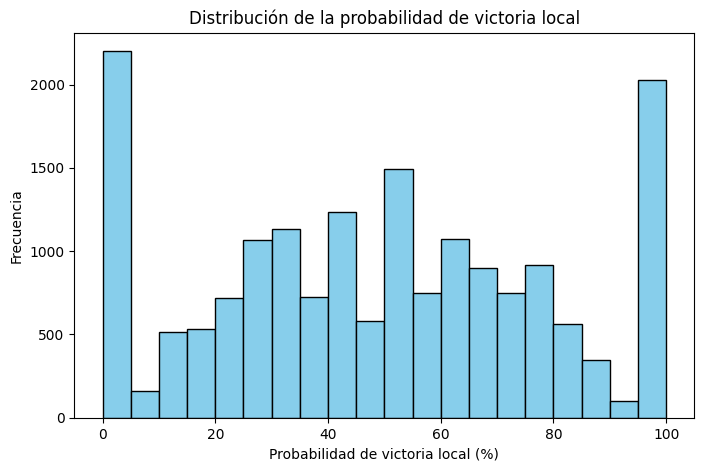

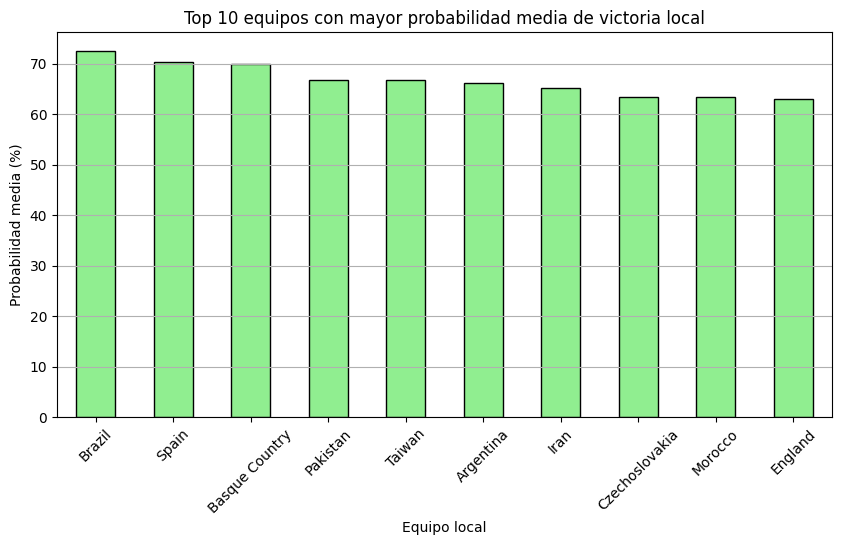

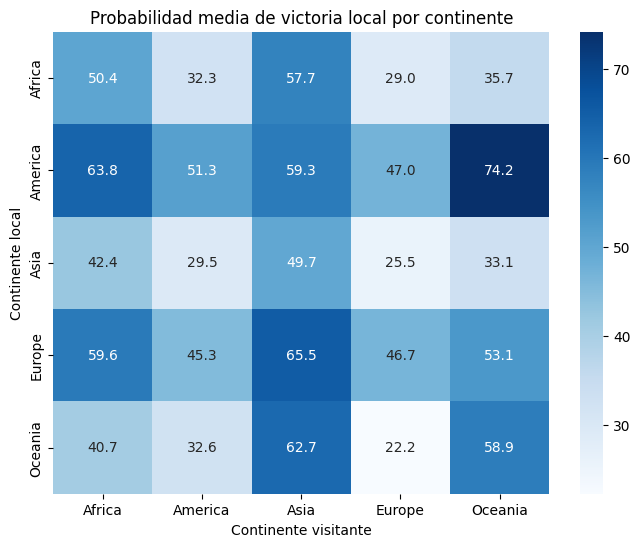

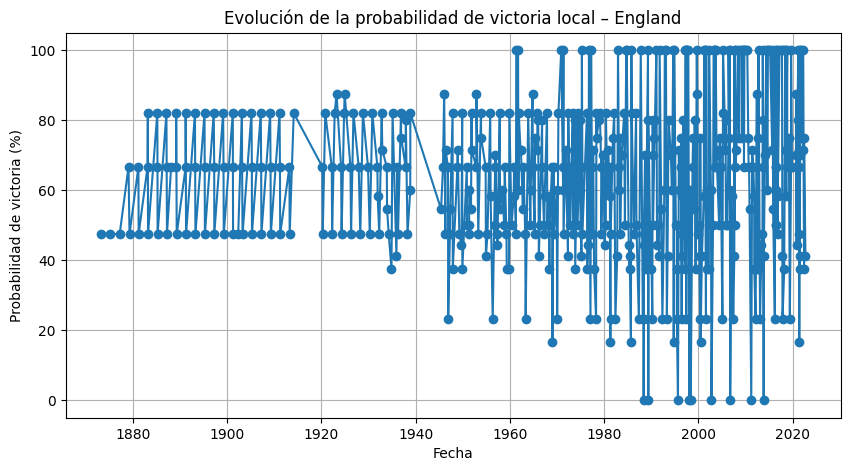

In [8]:
# ===============================================================
# 6. VISUALIZACIÓN DE LAS PROBABILIDADES DE VICTORIA
# ===============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Convertir a numérico (si aún está como objeto)
df_final["prob_home_win"] = pd.to_numeric(df_final["prob_home_win"], errors="coerce")

# ---------------------------------------------------------------
# 1. HISTOGRAMA DE PROBABILIDADES DE VICTORIA LOCAL
# ---------------------------------------------------------------
plt.figure(figsize=(8,5))
df_final["prob_home_win"].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Distribución de la probabilidad de victoria local")
plt.xlabel("Probabilidad de victoria local (%)")
plt.ylabel("Frecuencia")
plt.grid(False)
plt.show()

# ---------------------------------------------------------------
# 2. TOP 10 EQUIPOS CON MAYOR PROBABILIDAD MEDIA DE VICTORIA LOCAL
# ---------------------------------------------------------------
top10 = (
    df_final.groupby("Home Team")["prob_home_win"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top10.plot(kind="bar", color='lightgreen', edgecolor='black')
plt.title("Top 10 equipos con mayor probabilidad media de victoria local")
plt.ylabel("Probabilidad media (%)")
plt.xlabel("Equipo local")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# ---------------------------------------------------------------
# 3. HEATMAP: PROBABILIDAD MEDIA SEGÚN CONTINENTE LOCAL vs VISITANTE
# ---------------------------------------------------------------
heatmap_data = df_final.pivot_table(
    values="prob_home_win",
    index="Home_Continent",
    columns="Away_Continent",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".1f")
plt.title("Probabilidad media de victoria local por continente")
plt.xlabel("Continente visitante")
plt.ylabel("Continente local")
plt.show()

# ---------------------------------------------------------------
# 4. (OPCIONAL) EVOLUCIÓN TEMPORAL DE UN EQUIPO ESPECÍFICO
# ---------------------------------------------------------------
equipo = "England"  # puedes cambiarlo por otro
df_team = df_final[df_final["Home Team"] == equipo].sort_values("Date")

plt.figure(figsize=(10,5))
plt.plot(df_team["Date"], df_team["prob_home_win"], marker='o', linestyle='-')
plt.title(f"Evolución de la probabilidad de victoria local – {equipo}")
plt.xlabel("Fecha")
plt.ylabel("Probabilidad de victoria (%)")
plt.grid(True)
plt.show()